In [34]:
import serial
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# plt.switch_backend('Qt5Agg')


# Configuration
PORT = '/dev/ttyACM0'
BAUD_RATE = 115200
NUM_SAMPLES = 80000
print("ok")


ok


In [7]:
with serial.Serial(PORT, BAUD_RATE, timeout=None) as ser:
    print("Waiting to receive samples...")

    samples = []
    count = 0

    # Read NUM_SAMPLES lines
    for i in range(NUM_SAMPLES):
        line = ser.readline().strip()
        if not line:
            print("Warning: Received empty line, skipping.")
            continue
        
        try:
            sample_value = int(line)
            samples.append(sample_value)
        except ValueError:
            print(f"Warning: Could not parse line '{line}' as an integer.")
            continue
        
        count += 1
        if count % 10000 == 0:
            print(f"Received {count} samples...")

    if len(samples) < NUM_SAMPLES:
        print(f"Warning: Expected {NUM_SAMPLES} samples, but received {len(samples)}.")
    else:
        print("All samples successfully received and stored in memory.")

    print("First 10 samples:", samples[:10])

Waiting to receive samples...
Received 10000 samples...
Received 20000 samples...
Received 30000 samples...
Received 40000 samples...
Received 50000 samples...
Received 60000 samples...
Received 70000 samples...
Received 80000 samples...
All samples successfully received and stored in memory.
First 10 samples: [2075, 2041, 2060, 2064, 2048, 2034, 2057, 2070, 2026, 2059]


In [ ]:
SIGNAL_MEAN = 2050
SIGNAL_RANGE = 350
SIGNAL_RANGE_INV = 1/SIGNAL_RANGE


0.002857142857142857


In [9]:
def normalize(raw):
    normalized = (raw - SIGNAL_MEAN) * SIGNAL_RANGE_INV
    normalized = 1.0 if normalized > 1.0 else normalized
    normalized = -1.0 if normalized < -1.0 else normalized
    return normalized

In [13]:
normalized_samples = list(map(normalize, samples))

In [14]:
print("First 10 normalized samples:", normalized_samples[:10])

First 10 normalized samples: [0.07142857142857142, -0.025714285714285714, 0.02857142857142857, 0.04, -0.005714285714285714, -0.045714285714285714, 0.02, 0.05714285714285714, -0.06857142857142857, 0.025714285714285714]


In [22]:
print(normalized_samples[0])
print(type(normalized_samples[0]))


0.07142857142857142
<class 'float'>


In [35]:
def plot_array(y, sr):
    time = np.linspace(0, len(y) / sr, len(y))

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, y, label="Amplitude")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.grid()
    plt.tight_layout()
    plt.show()

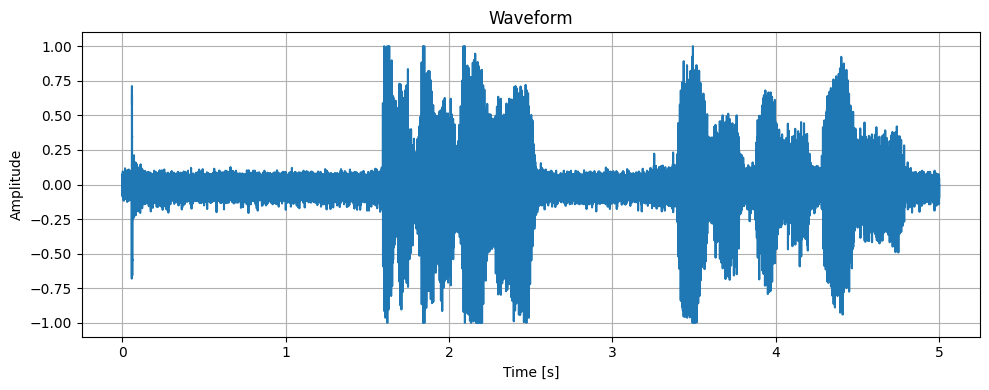

In [36]:
plot_array(normalized_samples, 16000)

In [43]:
from pydub import AudioSegment

normalized_samples = np.array(normalized_samples, dtype=np.float32)

int_samples = (normalized_samples * 32767).astype(np.int16)
raw_data = int_samples.tobytes()

# Create an AudioSegment. 
# - sample_width=2 for 16-bit audio
# - frame_rate=16000 as given
# - channels=1 (mono)
audio_segment = AudioSegment(
    data=raw_data,
    sample_width=2,
    frame_rate=16000,
    channels=1
)

In [50]:
from pydub.playback import play

play(audio_segment)

In [49]:
audio_segment.export("z_filtrem.mp3", format="mp3")

<_io.BufferedRandom name='z_filtrem.mp3'>

In [54]:
print(type(int_samples))
print(int_samples.shape)
print(type(int_samples[0]))
print(np.max(int_samples))
print(np.min(int_samples))

<class 'numpy.ndarray'>
(80000,)
<class 'numpy.int16'>
32767
-32767


In [ ]:
def audio_to_mfcc(audio_samples, sample_rate=16000,
                  n_mfcc=13, n_fft=512, win_length=400, hop_length=160,
                  fmin=20, fmax=None):
    # Convert int16 samples to floating point and normalize to [-1, 1]
    audio_float = audio_samples.astype(np.float32) / 32768.0
    
    # Compute MFCCs using librosa
    
    # Normalize MFCCs (mean normalization)
    mfcc_features -= (np.mean(mfcc_features, axis=1, keepdims=True) + 1e-8)
    
    return mfcc_features

In [57]:
from librosa.feature import mfcc

mfcc_features = mfcc(y=normalized_samples, sr=16000, n_mfcc=13, n_fft=512, hop_length=160, win_length=400, fmin=20, fmax=None)
mfcc_features -= (np.mean(mfcc_features, axis=0) + 1e-8)
